In [4]:
import pandas as pd
import duckdb
from pathlib import Path
import os
import numpy as np


DATA_FOLDER = Path("/home/akimovh/predatory_pricing_airlines/data")

con = duckdb.connect(DATA_FOLDER / "duckdb" / "airlines.duckdb")
con.execute(f"PRAGMA threads={os.cpu_count()}")          
con.execute("PRAGMA enable_progress_bar=true;")

def scalar(sql: str):
    return con.execute(sql).fetchone()[0]


# Step 1: Determining what markets to drop

In [5]:
# Base filter
t100 = con.execute("""
                select DEPARTURES_PERFORMED, SEATS, PASSENGERS, ORIGIN_CITY_MARKET_ID, DEST_CITY_MARKET_ID,
                                UNIQUE_CARRIER, CLASS, YEAR, QUARTER, MONTH
                from T100
                where DEPARTURES_PERFORMED > 0
                and CLASS = 'F'
            """).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [6]:
# Creating market_id - directional pair of origin and
routes = (
    t100[['ORIGIN_CITY_MARKET_ID', 'DEST_CITY_MARKET_ID']]
    .drop_duplicates()
    .sort_values(['ORIGIN_CITY_MARKET_ID','DEST_CITY_MARKET_ID'])
    .reset_index(drop=True)
)
routes['market_id'] = routes.index.astype('int64')

routes_path = DATA_FOLDER / "dict" / "routes.csv"
routes.to_csv(routes_path, index=False)

t100 = t100.merge(routes, on=['ORIGIN_CITY_MARKET_ID','DEST_CITY_MARKET_ID'], how='left')


(0.0, 2000.0)

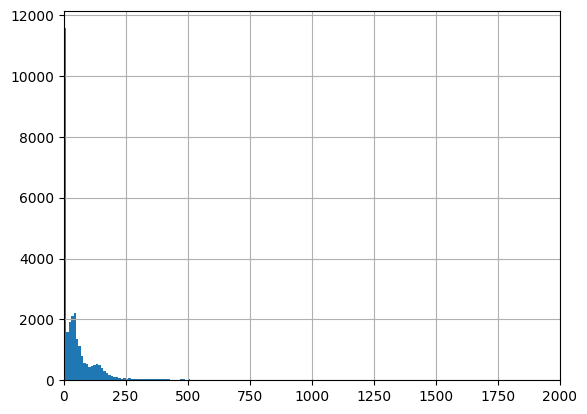

In [7]:
t100_quarter = t100.groupby(by=['UNIQUE_CARRIER', 'YEAR', 'QUARTER', 'market_id'], as_index=False)[['DEPARTURES_PERFORMED', 'SEATS', 'PASSENGERS']].sum()
t100_agg = t100_quarter.groupby(by=['YEAR', 'QUARTER', 'market_id'], as_index=False)[['DEPARTURES_PERFORMED', 'SEATS', 'PASSENGERS']].sum()
t100_agg_agg =  t100_agg.groupby(by=['market_id'], as_index=False)[['DEPARTURES_PERFORMED', 'SEATS', 'PASSENGERS']].mean()
fig = t100_agg_agg.query('PASSENGERS<10000').PASSENGERS.hist(bins = 1000)
fig.set_xlim(0, 2000)

(0.0, 100.0)

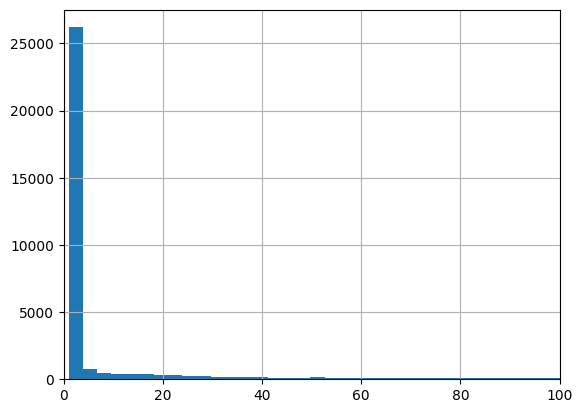

In [8]:
fig = t100_agg_agg.DEPARTURES_PERFORMED.hist(bins = 5000)
fig.set_xlim(0, 100)

I drop markets with less than 1000 passangers and less than 12 departures total.

In [9]:
# Drop markets with less than 500 passangers per quarter on average
mkts = t100_agg_agg.query('PASSENGERS > 1000 and DEPARTURES_PERFORMED>=12').market_id.unique()
t100 = t100.query("market_id in @mkts")
t100_quarter = t100_quarter.query("market_id in @mkts")
t100_agg = t100_agg.query("market_id in @mkts")

# Step 2: For markets left, I want do determine quarters that they properly existed.

It might be that the average number of passengers is greater than 1000, but some quarters will have like 10 passengers. I want to drop those quarters for corresponding markets

(0.0, 2000.0)

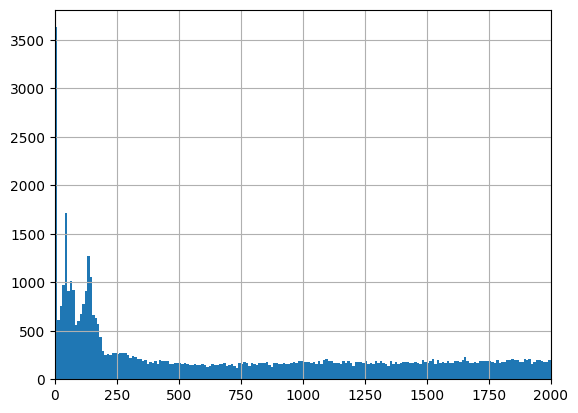

In [10]:
fig = t100_agg.query('PASSENGERS<10000').PASSENGERS.hist(bins = 1000)
fig.set_xlim(0, 2000)

In [11]:
tmp = t100_agg.query('PASSENGERS > 250 and DEPARTURES_PERFORMED>=6')[['market_id', 'YEAR', 'QUARTER']].drop_duplicates()
t100 = pd.merge(t100, tmp, on = ['market_id', 'YEAR', 'QUARTER'], how = 'inner')
t100_quarter = pd.merge(t100_quarter, tmp, on = ['market_id', 'YEAR', 'QUARTER'], how = 'inner')


Droppping quarter-market pairs with less than 250 passangers or less than 6 departures (at least biweekly).

# Step 3: filter the Carriers

(0.0, 2000.0)

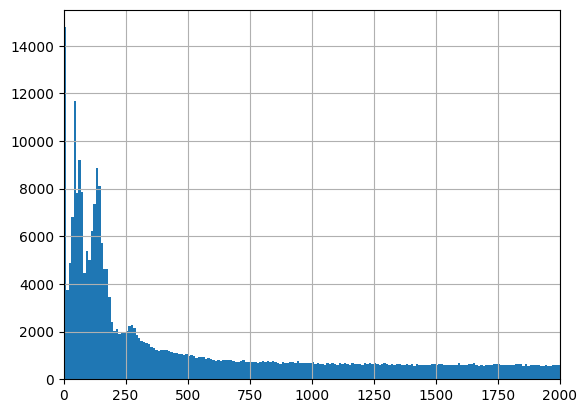

In [12]:
t100_quarter['market_size'] = t100_quarter.groupby(by=['YEAR', 'QUARTER', 'market_id']).PASSENGERS.transform('sum')
t100_quarter['market_share'] = t100_quarter.PASSENGERS/t100_quarter.market_size *100
fig = t100_quarter.query('PASSENGERS<10000').PASSENGERS.hist(bins = 1000)
fig.set_xlim(0, 2000)

In [13]:
t100_quarter = t100_quarter.query('market_share>1 and PASSENGERS > 250 and DEPARTURES_PERFORMED >= 6')
tmp = t100_quarter[['market_id', 'YEAR', 'QUARTER', 'UNIQUE_CARRIER']].drop_duplicates()
t100 = pd.merge(t100, tmp, on = ['market_id', 'YEAR', 'QUARTER', 'UNIQUE_CARRIER'], how = 'inner')
t100['date'] = pd.to_datetime(
            t100['YEAR'].astype(str) + '-' +
            (t100['MONTH']).astype(str) + '-01'
        )
t100_quarter['date'] = pd.to_datetime(
            t100_quarter['YEAR'].astype(str) + '-' +
            ((t100_quarter['QUARTER'] - 1) * 3 + 1).astype(str) + '-01'
        )

Droppping carriers with less than 1% market share and with less than 250 passangers or less than 6 departures (at least biweekly).

In [14]:
valid_t100_keys = t100_quarter[['date', 'market_id', 'UNIQUE_CARRIER']].drop_duplicates()

# Step 4: Creating the big panel with prices

T100 data is for operating carriers, we need to match it to OpCarriers in DB1B, then find a list of markets which SW entered as TkCarrier since 2010


In [15]:
con.register("valid_t100_keys_df", valid_t100_keys)
con.register("routes_df", routes)

In [16]:
# FINAL: build DB1B_processed (fare>10 & <2500 + guarded 1–99% pax trim + market shares + final filters)
con.execute("""

CREATE OR REPLACE TABLE routes AS (
    SELECT DISTINCT ORIGIN_CITY_MARKET_ID, DEST_CITY_MARKET_ID, market_id
    FROM routes_df
);
            
CREATE OR REPLACE TABLE DB1B_processed AS
WITH

-- Uploading df to database

valid_t100_keys_u AS (
    SELECT DISTINCT date, market_id, UNIQUE_CARRIER
    FROM valid_t100_keys_df
),

-- Filter only valid markets from t100 + basic filter

base AS (
    SELECT
        m.TkCarrier,
        m.OriginCityMarketID,
        m.DestCityMarketID,
        m.Year::INT    AS Year,
        m.Quarter::INT AS Quarter,
        m.OpCarrier,
        ROUND(m.MktFare::DOUBLE, 2) AS fare,
        m.Passengers::DOUBLE AS pax,
        make_date(m.Year::INT, (m.Quarter::INT - 1) * 3 + 1, 1) AS date,
        COALESCE(m.OriginState, 'NA') AS OriginState,
        COALESCE(m.DestState,   'NA') AS DestState,
        r.market_id
    FROM DB1B_Market m
    JOIN routes r
      ON m.OriginCityMarketID = r.ORIGIN_CITY_MARKET_ID
     AND m.DestCityMarketID   = r.DEST_CITY_MARKET_ID
    JOIN valid_t100_keys_u k
      ON make_date(m.Year::INT, (m.Quarter::INT - 1) * 3 + 1, 1) = k.date
     AND r.market_id = k.market_id
     AND m.OpCarrier = k.UNIQUE_CARRIER
    WHERE m.MktCoupons = 1
      AND m.MktFare > 10
      AND m.MktFare < 2500
      AND m.BULKFARE = 0
),

-- Trim top and bottop quantiles

fare_bins AS (
    SELECT
        TkCarrier, OriginCityMarketID, DestCityMarketID, Year, Quarter, date, market_id,
        fare, OriginState, DestState,
        SUM(pax) AS pax
    FROM base
    GROUP BY 1,2,3,4,5,6,7,8,9,10
),
cdf AS (
    SELECT
        *,
        SUM(pax) OVER (PARTITION BY Year, Quarter, market_id, TkCarrier) AS pax_total,
        COUNT(*) OVER (PARTITION BY Year, Quarter, market_id, TkCarrier) AS bin_count,
        SUM(pax) OVER (
            PARTITION BY Year, Quarter, market_id, TkCarrier
            ORDER BY fare
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS pax_cum
    FROM fare_bins
),
trimmed AS (
    SELECT *
    FROM cdf
    WHERE CASE
            WHEN pax_total >= 500 AND bin_count >= 5 THEN
                 (pax_cum / NULLIF(pax_total, 0)) > 0.01
             AND (pax_cum / NULLIF(pax_total, 0)) < 0.99
            ELSE TRUE
          END
),

-- Final trimming: create variables + only carriers with market share > 1 percent

carrier_q AS (
    SELECT
        TkCarrier,
        OriginCityMarketID,
        DestCityMarketID,
        Year,
        Quarter,
        date,
        market_id,
        OriginState,
        DestState,
        SUM(pax)            AS Passengers,
        SUM(pax * fare)     AS sum_fares,
        SUM(pax * LN(fare)) AS sum_log_fares
    FROM trimmed
    GROUP BY 1,2,3,4,5,6,7,8,9
),
with_shares AS (
    SELECT
        *,
        (sum_fares / NULLIF(Passengers, 0)) AS avg_fare_q,
        100.0 * Passengers
          / NULLIF(SUM(Passengers) OVER (PARTITION BY Year, Quarter, market_id), 0) AS market_share
    FROM carrier_q
)
SELECT *
FROM with_shares
where market_share > 1 AND Passengers > 25
;
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

# Step 5: filter big panel + add required columns

In this part we:

- Only markets with sw entry past 2011 or never
- Markets existed a year before sw entry
- Only data start 2010
- Flags: covid, route_covid, HI, SW_presence, monopoly_market

In [17]:
con.execute("""
-- 1. Market presence 

CREATE OR REPLACE TABLE final_panel AS
WITH 

route_presence AS (
    SELECT DISTINCT date, market_id, TkCarrier
    FROM DB1B_processed
    ),

sw_entry AS (
    SELECT market_id, MIN(date) AS SW_entry_date
    FROM route_presence
    WHERE TkCarrier='WN'
    GROUP BY 1
    ),

-- 3. Final Panel 
filt_markets AS (
    SELECT DISTINCT rp.market_id,
                    se.SW_entry_date
    FROM route_presence rp
    LEFT JOIN sw_entry se USING (market_id)
    WHERE se.SW_entry_date IS NULL
        OR se.SW_entry_date >= DATE '2011-01-01'
),
df AS (
    SELECT
        p.date,
        p.market_id,
        p.TkCarrier,
        p.OriginState,
        p.DestState,
        p.Passengers,
        p.sum_fares,
        p.sum_log_fares,
        COALESCE(fm.SW_entry_date, DATE '2030-01-01') AS SW_entry_date,
        CASE
            WHEN fm.SW_entry_date IS NULL THEN -100
            ELSE (EXTRACT(year FROM p.date) - EXTRACT(year FROM fm.SW_entry_date)) * 4
                + (EXTRACT(quarter FROM p.date) - EXTRACT(quarter FROM fm.SW_entry_date))
        END AS rel_period,
        CASE
            WHEN fm.SW_entry_date IS NULL THEN 0
            ELSE CASE WHEN
                (EXTRACT(year FROM p.date) - EXTRACT(year FROM fm.SW_entry_date)) * 4
              + (EXTRACT(quarter FROM p.date) - EXTRACT(quarter FROM fm.SW_entry_date)) >= 0
            THEN 1 ELSE 0 END
        END AS post_SW_entry
    FROM DB1B_processed p
    INNER JOIN filt_markets fm USING (market_id)
),
stable_treated_markets AS (
    SELECT market_id
    FROM df
    WHERE rel_period BETWEEN -4 AND 0
      AND SW_entry_date <> DATE '2030-01-01'
    GROUP BY 1
    HAVING COUNT(DISTINCT rel_period) = 5
),
df_stable AS (
    SELECT t1.*,
           CASE WHEN t1.date >= DATE '2020-03-01' AND t1.date <= DATE '2021-01-01' THEN 1 ELSE 0 END AS covid,
           count(distinct TkCarrier) over (partition by date, market_id) as ncarriers,
           MAX(CASE WHEN t1.OriginState='HI' AND t1.DestState='HI' THEN 1 ELSE 0 END) over (partition by  market_id) AS ihi_routes,
           MAX(CASE WHEN t1.OriginState='HI' OR  t1.DestState='HI' THEN 1 ELSE 0 END) over (partition by  market_id) AS hi_routes,
           MAX(CASE WHEN t1.OriginState='HI' AND t1.DestState='HI' and TkCarrier = 'WN' THEN 1 ELSE 0 END) over (partition by market_id) AS target_routes,
           sum_fares/Passengers as mean_fare,
           sum_log_fares/Passengers as mean_log_fare,
           case when market_id in (
                                    select market_id
                                    from (  select market_id 
                                            from df
                                            where rel_period = -1
                                            group by market_id
                                            having count(distinct TkCarrier) = 1 
                                            intersect
                                            select distinct market_id 
                                            from df
                                            where rel_period = -2
                                            group by market_id
                                            having count(distinct TkCarrier) = 1 
                                            )
                                    union all 
                                        select market_id
                                        from  (
                                                select market_id, date, count(distinct TkCarrier) as nc
                                                from df 
                                                where rel_period == -100
                                                group by market_id, date
                                            )   
                                        group by market_id
                                        having max(nc) = 1
                                   ) then 1 else 0 end as monopoly_market
            
    FROM df as t1
    WHERE SW_entry_date = DATE '2030-01-01'
       OR market_id IN (SELECT market_id FROM stable_treated_markets)
) -- NO Semicolon here
SELECT *
FROM df_stable
where date >= '2010-01-01'
    and ((rel_period>-17 and rel_period<17) or rel_period ==-100);
""")

In [18]:
# ---- 1) Pull panel from DuckDB
panel = con.execute("SELECT * FROM final_panel").df()

# ---- 2) Types / dates (minimal but important)
panel["date"] = pd.to_datetime(panel["date"])
panel["SW_entry_date"] = pd.to_datetime(panel["SW_entry_date"])

# ensure ints where your logic expects ints
for c in ["rel_period", "post_SW_entry", "covid", "target_routes", "hi_routes", "monopoly_market", "ncarriers"]:
    if c in panel.columns:
        panel[c] = panel[c].astype(int)

# route_covid can be float/object depending on how you built it; not needed for table, but keep it safe
if "route_covid" in panel.columns:
    # if it came as float like 0.0, keep numeric; otherwise cast to string
    try:
        panel["route_covid"] = panel["route_covid"].astype("Int64")
    except Exception:
        panel["route_covid"] = panel["route_covid"].astype(str)

# ---- 3) If you only have sum_fares / Passengers, ensure mean_fare exists (same for log)
if "mean_fare" not in panel.columns:
    panel["mean_fare"] = panel["sum_fares"] / panel["Passengers"].replace(0, np.nan)

if "mean_log_fare" not in panel.columns:
    panel["mean_log_fare"] = panel["sum_log_fares"] / panel["Passengers"].replace(0, np.nan)

# =========================
# Your original function (unchanged logic, just using panel from DuckDB)
# =========================

def generate_descriptive_table(panel, sample_label, target_routes_flag=None, monopoly_flag=None):
    # Filter panel based on flags
    if target_routes_flag is not None:
        panel = panel[panel['target_routes'] == target_routes_flag]
    if monopoly_flag is not None:
        panel = panel[panel['monopoly_market'] == monopoly_flag]

    # Average and median numbers SW stays at the market after entering
    sw_panel = panel[(panel['rel_period'] >= 0) & (panel['rel_period'] <= 15)]

    def count_sw_periods(market_data):
        market_data = market_data.sort_values('rel_period')
        consecutive_periods = 0
        for _, row in market_data.iterrows():
            if row['post_SW_entry'] == 1:
                consecutive_periods += 1
            else:
                break
        return min(consecutive_periods, 16)

    sw_periods_by_market = sw_panel.groupby('market_id').apply(count_sw_periods)
    sw_stay_stats = sw_periods_by_market.agg(['mean', 'median'])

    # Basic statistics for key variables
    basic_stats = panel[['mean_fare', 'ncarriers', 'Passengers']].agg(['mean', 'std', 'min', 'max']).T

    # Pre and post entry statistics
    panel = panel.copy()
    panel['period_type'] = np.where(panel['rel_period'] < 0, 'pre', 'post')
    pre_post_stats = panel.groupby('period_type')[['mean_fare', 'ncarriers', 'Passengers']].agg(['mean', 'std']).T

    # Reshape the pre_post_stats for better presentation
    pre_post_reshaped = pd.DataFrame(index=pre_post_stats.index.get_level_values(0).unique())
    for var in pre_post_stats.index.get_level_values(0).unique():
        pre_post_reshaped.loc[var, 'pre_mean'] = pre_post_stats.loc[(var, 'mean'), 'pre']
        pre_post_reshaped.loc[var, 'pre_std']  = pre_post_stats.loc[(var, 'std'),  'pre']
        pre_post_reshaped.loc[var, 'post_mean'] = pre_post_stats.loc[(var, 'mean'), 'post']
        pre_post_reshaped.loc[var, 'post_std']  = pre_post_stats.loc[(var, 'std'),  'post']

        # Calculate post/pre ratio
        if pre_post_reshaped.loc[var, 'pre_mean'] != 0:
            pre_post_reshaped.loc[var, 'ratio'] = pre_post_reshaped.loc[var, 'post_mean'] / pre_post_reshaped.loc[var, 'pre_mean']
        else:
            pre_post_reshaped.loc[var, 'ratio'] = np.nan

    # Renamed index
    renamed_index = {
        'mean_fare': 'Average market-quarter fare',
        'Passengers': '\\# Passengers per quarter',
        'ncarriers': '\\# Carriers in the market'
    }

    # Rename the index of both DataFrames
    basic_stats.index = [renamed_index.get(idx, idx) for idx in basic_stats.index]
    pre_post_reshaped.index = [renamed_index.get(idx, idx) for idx in pre_post_reshaped.index]

    final_stats = pd.concat([basic_stats, pre_post_reshaped], axis=1)

    # Panel balance information
    markets_count = panel['market_id'].nunique()
    periods_count = panel['date'].nunique()
    actual_obs = len(panel)

    panel_info = pd.DataFrame({
        'mean': [sw_stay_stats['mean'], int(markets_count), int(periods_count), int(actual_obs)],
        'std':  [sw_stay_stats['median'], np.nan, np.nan, np.nan],
        'min':  [np.nan, np.nan, np.nan, np.nan],
        'max':  [np.nan, np.nan, np.nan, np.nan]
    }, index=['SW Stay Periods', '\\# Markets', '\\# Time Periods', 'N'])

    final_stats = pd.concat([final_stats, panel_info])
    final_stats = final_stats.round(2)

    return final_stats


# =========================
# Build three samples
# =========================
full_sample_stats     = generate_descriptive_table(panel, 'Full Sample')
monopoly_stats        = generate_descriptive_table(panel, 'Monopoly Markets', monopoly_flag=1)
targeted_routes_stats = generate_descriptive_table(panel, 'Targeted Routes', target_routes_flag=1)

# =========================
# LaTeX table generation (your original structure)
# =========================

latex = "\\begin{table}[htbp]\n\\centering\n\\caption{Descriptive Statistics}\n\\label{tab:descriptive}\n"
latex += "\\resizebox{\\textwidth}{!}{% shrink to fit page width\n"
latex += "\\begin{tabular}{l cccc cccc c}\n\\toprule\n"

latex += " & \\multicolumn{4}{c}{Full Sample} & \\multicolumn{4}{c}{Pre vs. Post Entry} & \\multicolumn{1}{c}{Ratio} \\\\\n"
latex += "\\cmidrule(lr){2-5} \\cmidrule(lr){6-9} \\cmidrule(lr){10-10}\n"
latex += " & Mean & Std. & Min & Max & Pre & Std. & Post & Std. & Post/Pre \\\\[2pt]\n"
latex += "\\midrule\n"

int_rows = ['\\# Markets', '\\# Time Periods', 'N']

def add_block(stats, title):
    global latex
    latex += f"\\multicolumn{{10}}{{l}}{{\\textbf{{{title}}}}} \\\\\n"
    latex += " &  &  &  &  &  &  &  &  &  \\\\\n"
    for idx, row in stats.iterrows():
        row_latex = f"{idx} & "

        # basic stats
        for col in ['mean', 'std', 'min', 'max']:
            val = row.get(col, np.nan)
            if pd.isna(val):
                row_latex += " & "
            elif idx in int_rows:
                row_latex += f"{int(val)} & "
            else:
                row_latex += f"{val:.2f} & "

        # pre/post stats
        for col in ['pre_mean', 'pre_std', 'post_mean', 'post_std']:
            val = row.get(col, np.nan)
            if pd.isna(val):
                row_latex += ""
            else:
                row_latex += f"{val:.2f}"
            row_latex += " & " if col != 'post_std' else " & "

        # ratio only for first three variables
        if idx in ['Average market-quarter fare', '\\# Carriers in the market', '\\# Passengers per quarter']:
            val = row.get('ratio', np.nan)
            row_latex += f"{val:.2f} \\\\\n" if not pd.isna(val) else " \\\\\n"
        else:
            row_latex += " \\\\\n"

        latex += row_latex

        if idx == '\\# Passengers per quarter':
            latex += " &  &  &  &  &  &  &  &  &  \\\\\n"
            latex += " & Mean & Median &  &  &  &  &  &  &  \\\\\n"
        if idx == 'SW Stay Periods':
            latex += " &  &  &  &  &  &  &  &  &  \\\\\n"

# Full sample
add_block(full_sample_stats, "Full Sample")
latex += " &  &  &  &  &  &  &  &  &  \\\\\n\\midrule\n"

# Monopoly sample
add_block(monopoly_stats, "Markets that were monopoly before SW entry")
latex += " &  &  &  &  &  &  &  &  &  \\\\\n\\midrule\n"

# Targeted routes sample
add_block(targeted_routes_stats, "Intra-Hawaiian Markets")

latex += " &  &  &  &  &  &  &  &  &  \\\\\n"
latex += "\\bottomrule\n"
latex += "\\end{tabular}}\n"
latex += "\\begin{tablenotes}\n\\small\n"
latex += "\\item Notes: This table presents descriptive statistics for the full sample of markets that faced Southwest entry and two subsamples: markets that were monopoly before SW entry and intra-Hawaiian markets. "
latex += "'Pre-Entry' refers to periods before Southwest entry, while 'Post-Entry' refers to periods after entry. "
latex += "The Southwest stay periods metric represents the average number of consecutive periods Southwest remains in a market after entry. "
latex += "Post/Pre column shows the ratio of post-entry to pre-entry means.\n"
latex += "\\end{tablenotes}\n"
latex += "\\end{table}"

print(latex)


\begin{table}[htbp]
\centering
\caption{Descriptive Statistics}
\label{tab:descriptive}
\resizebox{\textwidth}{!}{% shrink to fit page width
\begin{tabular}{l cccc cccc c}
\toprule
 & \multicolumn{4}{c}{Full Sample} & \multicolumn{4}{c}{Pre vs. Post Entry} & \multicolumn{1}{c}{Ratio} \\
\cmidrule(lr){2-5} \cmidrule(lr){6-9} \cmidrule(lr){10-10}
 & Mean & Std. & Min & Max & Pre & Std. & Post & Std. & Post/Pre \\[2pt]
\midrule
\multicolumn{10}{l}{\textbf{Full Sample}} \\
 &  &  &  &  &  &  &  &  &  \\
Average market-quarter fare & 209.34 & 104.77 & 13.92 & 1418.73 & 212.79 & 108.01 & 182.26 & 68.84 & 0.86 \\
\# Carriers in the market & 1.81 & 1.17 & 1.00 & 8.00 & 1.66 & 1.06 & 3.05 & 1.25 & 1.84 \\
\# Passengers per quarter & 652.72 & 1064.04 & 26.00 & 25621.00 & 587.50 & 950.20 & 1165.22 & 1624.24 & 1.98 \\
 &  &  &  &  &  &  &  &  &  \\
 & Mean & Median &  &  &  &  &  &  &  \\
SW Stay Periods & 15.63 & 16.00 &  &  &  &  &  &  &  \\
 &  &  &  &  &  &  &  &  &  \\
\# Markets & 5012 &  & 

In [19]:
con.close()